In [1]:
import cv2
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

In [2]:
def motion_blur_kernel(length, angle):
    M = cv2.getRotationMatrix2D((length / 2, length / 2), angle, 1)
    psf = np.diag(np.ones(length))
    psf = cv2.warpAffine(psf, M, (length, length))
    psf = psf / psf.sum()
    return psf

def wiener_deconvolution(img, kernel, K):
    kernel = np.flipud(np.fliplr(kernel))
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s=img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.fft.ifft2(dummy)
    dummy = np.abs(dummy)

    # Normalize the result to be in the range [0, 255]
    dummy = np.clip(dummy, 0, 255)
    return dummy.astype(np.uint8)

def deblur_color_image(img, kernel, K):
    # Split the image into its color channels
    b, g, r = cv2.split(img)
    
    # Apply Wiener deconvolution to each channel
    b_deblurred = wiener_deconvolution(b, kernel, K)
    g_deblurred = wiener_deconvolution(g, kernel, K)
    r_deblurred = wiener_deconvolution(r, kernel, K)
    
    # Merge the deblurred channels back together
    deblurred_img = cv2.merge((b_deblurred, g_deblurred, r_deblurred))
    
    return deblurred_img


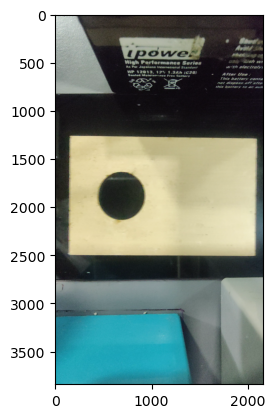

In [67]:
# Open the video file
cap = cv2.VideoCapture(r'F:\Bracket images\Videos from mobile\v4.mp4')

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Set the frame number you want to save
frame_number = 275 # Change this to the desired frame number

# Set the frame index to the desired frame number
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame at the desired frame number
ret, frame = cap.read()

# Check if the frame was successfully read
if not ret:
    print("Error: Could not read frame.")
    exit()

# Save the frame as an image
# cv2.imwrite('output_frame_122.jpg', frame)
rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
# Release the video capture object
cap.release()

# img_p = r'F:\Bracket images\f7.jpg'
# img = cv2.imread(img_p)
# rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plt.imshow(rgb_image)

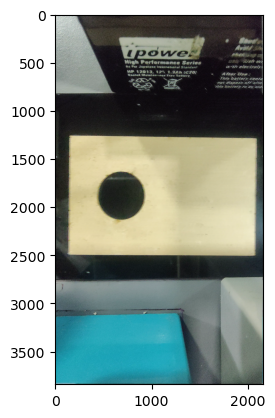

In [68]:
# Parameters
length = 7  # Length of the motion blur
angle = 180   # Angle of the motion blur
K = 0.007     # Regularization constant for Wiener filter

# Generate kernel
kernel = motion_blur_kernel(length, angle)

# Deblur the color image
deblurred_img = deblur_color_image(rgb_image, kernel, K)
plt.imshow(deblurred_img)

In [69]:
print(kernel)

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.16666667 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.16666667 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.16666667 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.16666667 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.16666667
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.16666667]]


In [70]:
def sharpen_image(image):
    # Create a kernel for sharpening
    sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
    # Apply the sharpening kernel to the image
    sharpened = cv2.filter2D(image, -1, sharpening_kernel)
    
    return sharpened

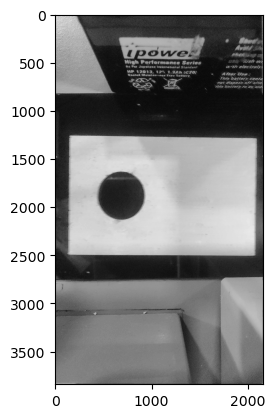

In [71]:
gray = cv2.cvtColor(deblurred_img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

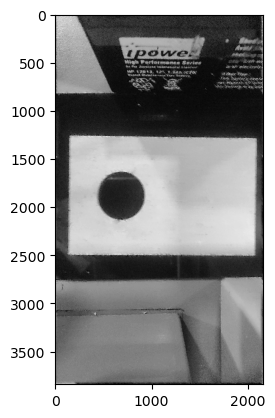

In [72]:
def preprocessing(gray):
    sharpened_img = sharpen_image(gray)
    # sharpened_img2 = sharpen_image(sharpened_img)
    med_blurred = cv2.medianBlur(sharpened_img, 7)
    # med_blurred2 = cv2.medianBlur(med_blurred,7)
    # sharpened_img3 = sharpen_image(med_blurred)
    # plt.imshow(sharpened_img3)

    return med_blurred

final_image = preprocessing(gray)
plt.imshow(final_image, cmap='gray')

In [73]:
def contour_drawer(gray_image,num, show_img = True, binary_thresh =(30,60), color = (0, 255, 0)):
    # rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
    lower_threshold = binary_thresh[0]
    upper_threshold = binary_thresh[1]

# Apply custom thresholding
    binary_image = np.zeros_like(gray_image)
    binary_image[(gray_image >= lower_threshold) & (gray_image <= upper_threshold)] = 255
    # _, binary_image = cv2.threshold(gray_image, binary_thresh[0], binary_thresh[1], cv2.THRESH_BINARY)
    img_copy = rgb_image.copy()
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    if show_img == True:	
        img_copy2 = rgb_image.copy()
        
        img_copy2 = cv2.drawContours(img_copy2, contours[num], -1, color, 10)
        plt.imshow(img_copy2)

    return contours, len(contours),binary_image   

23606


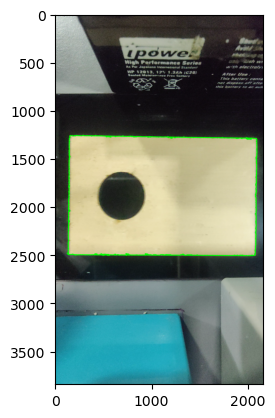

In [77]:
contours, length,bin_image = contour_drawer(final_image,0,binary_thresh=(130,250))
print(length)

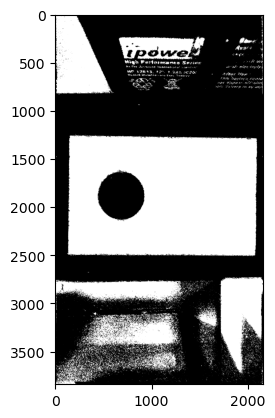

In [78]:
plt.imshow(bin_image, cmap='gray')

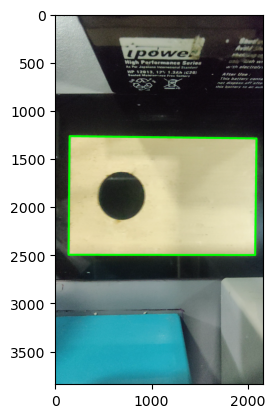

In [79]:
def contour_approximation(image,contours,num,precision):
    epsilon = precision * cv2.arcLength(contours[0], True)

    # Approximate the contour
    approx = cv2.approxPolyDP(contours[num], epsilon, True)
    smooth = rgb_image.copy()
    # Draw the approximated contour (in red)
    smooth = cv2.drawContours(smooth, [approx], -1, (0, 255, 0), 20)
    plt.imshow(smooth)

    return smooth,approx

smoothened_image, approx = contour_approximation(final_image, contours,0,0.03)

In [80]:
print(approx)

[[[ 151 1267]]

 [[ 140 2498]]

 [[2078 2501]]

 [[2092 1291]]]


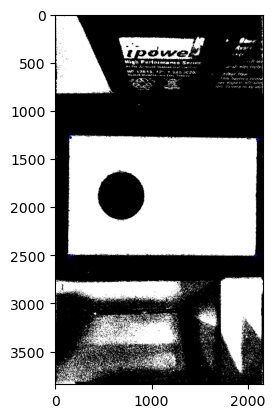

In [81]:
image_c = bin_image.copy()
# plt.imshow(image_c)
x = [i[0][0] for i in approx]
y = [i[0][1] for i in approx]

plt.imshow(image_c, cmap = 'gray')
plt.scatter(x,y,color = 'blue', s = 1)

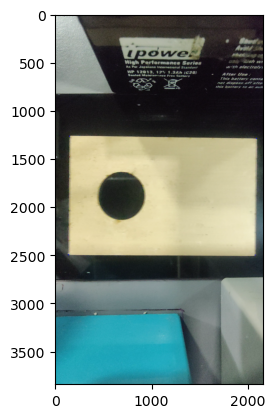

In [82]:
image_c = rgb_image.copy()
plt.imshow(image_c)
for i in approx:
    image_c = cv2.circle(image_c, i[0], 5, (0,0,255), -1)
plt.imshow(image_c)

2418


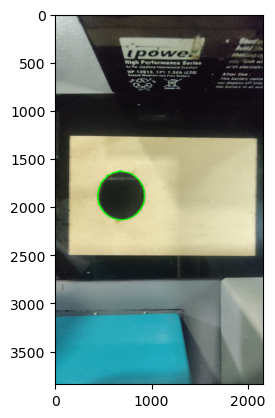

In [88]:
contours, length, bin_image = contour_drawer(final_image,5, binary_thresh=(130,250))
circle = np.array(contours[5])
print(len(circle))

In [89]:
print(contours[5].shape)
print(len(contours[5]))
circ_contour = contours[5]
circ_contour.shape = (circ_contour.shape[0], 2)

(2418, 1, 2)
2418


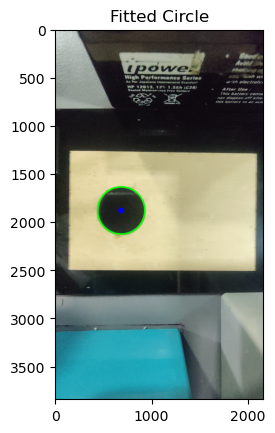

In [90]:
# Function to fit a circle to a set of points
def fit_circle(points):
    x = points[:, 0]
    y = points[:, 1]
    A = np.column_stack([x, y, np.ones(x.shape[0])])
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    center_x = c[0] / 2
    center_y = c[1] / 2
    radius = np.sqrt(c[2] + center_x**2 + center_y**2)
    return center_x, center_y, radius


# Fit a circle to the contour points
center_x, center_y, radius = fit_circle(circ_contour)

# Draw the fitted circle on the image
smooth = rgb_image.copy()
cv2.circle(smooth, (int(center_x), int(center_y)), int(radius), (0, 255, 0), 15)
cv2.circle(smooth, (int(center_x), int(center_y)), 30, (0,0,255), -1)

# Display the result using matplotlib
plt.imshow(smooth)
plt.title('Fitted Circle')
plt.show()

In [91]:
print(approx)

[[[ 151 1267]]

 [[ 140 2498]]

 [[2078 2501]]

 [[2092 1291]]]


In [ ]:
def convert_mm(dis):
    return (0.0406969697*dis)

In [94]:
def measure_euclidean(p1,p2):
    # print(p1)
    x1, y1 = p1
    x2, y2 = p2
    
    dist = ((x2-x1)**2 + (y2-y1)**2)**0.5
    return dist

print(measure_euclidean(approx[0][0], approx[3][0]), "  ", convert_mm(measure_euclidean(approx[0][0], approx[3][0])))
print(measure_euclidean(approx[0][0], approx[1][0]), "  ", convert_mm(measure_euclidean(approx[0][0], approx[1][0])))
print(measure_euclidean(approx[1][0], approx[2][0]), "  ", convert_mm(measure_euclidean(approx[1][0], approx[2][0])))
print(measure_euclidean(approx[2][0], approx[3][0]), "  ", convert_mm(measure_euclidean(approx[2][0], approx[3][0])))


print("\nfor circle\n")
print(measure_euclidean(approx[0][0], [int(center_x),int(center_y)]), "  ", convert_mm(measure_euclidean(approx[0][0], [int(center_x),int(center_y)])))
print(measure_euclidean(approx[3][0], [int(center_x),int(center_y)]), "  ", convert_mm(measure_euclidean(approx[3][0], [int(center_x),int(center_y)])))
print(measure_euclidean(approx[1][0], [int(center_x),int(center_y)]), "  ", convert_mm(measure_euclidean(approx[1][0], [int(center_x),int(center_y)])))
print(measure_euclidean(approx[2][0], [int(center_x),int(center_y)]), "  ", convert_mm(measure_euclidean(approx[2][0], [int(center_x),int(center_y)])))


1941.1483714543822    78.99885645628333
1231.0491460538851    50.09996979616584
1938.0023219800332    78.87082177615106
1210.0809890251148    49.24662934490113

for circle

816.5488350368274    33.231063198064064
1524.6274954886521    62.04771898768857
823.0637885364657    33.496202063235756
1522.1054496978848    61.945079366559696
